In [1]:
import numpy as np
import pickle
from matplotlib import pyplot as plt
from scipy.linalg import hankel
from utils import params

In [2]:
with open('Results/Model1_Linear_6stations/final_output.pkl', 'rb') as f:
    results = pickle.load(f)
X_ori = results['x'].cpu().detach().numpy()
dx_ori = results['dx'].cpu().detach().numpy()
z = results['z'].cpu().detach().numpy()
sindy_coeff = results['sindy_coefficients'].cpu().detach().numpy()
Theta = results['Theta'].cpu().detach().numpy()

measured_index = [i*params['embedding_dimension'] for i in range(params['partial_measurement'])]
X_ori = X_ori[:, measured_index]
dx_ori = dx_ori[:, measured_index]

In [3]:
# e, _ = np.linalg.eig(sindy_coeff)

In [4]:
train_loss = np.load("Results/Model1_Linear_6stations/train_loss.npy")
val_loss = np.load("Results/Model1_Linear_6stations/val_loss.npy")
refine_loss = np.load("Results/Model1_Linear_6stations/refine_loss.npy")
refine_val_loss = np.load("Results/Model1_Linear_6stations/refine_val_loss.npy")

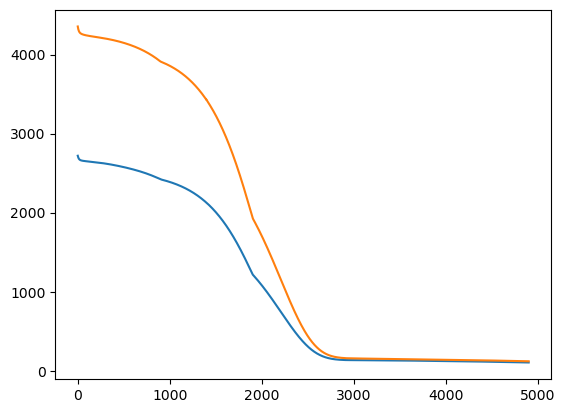

In [5]:
plt.plot(train_loss[100:])
plt.plot(val_loss[100:])

In [6]:
# plt.plot(refine_loss)
# plt.plot(refine_val_loss)

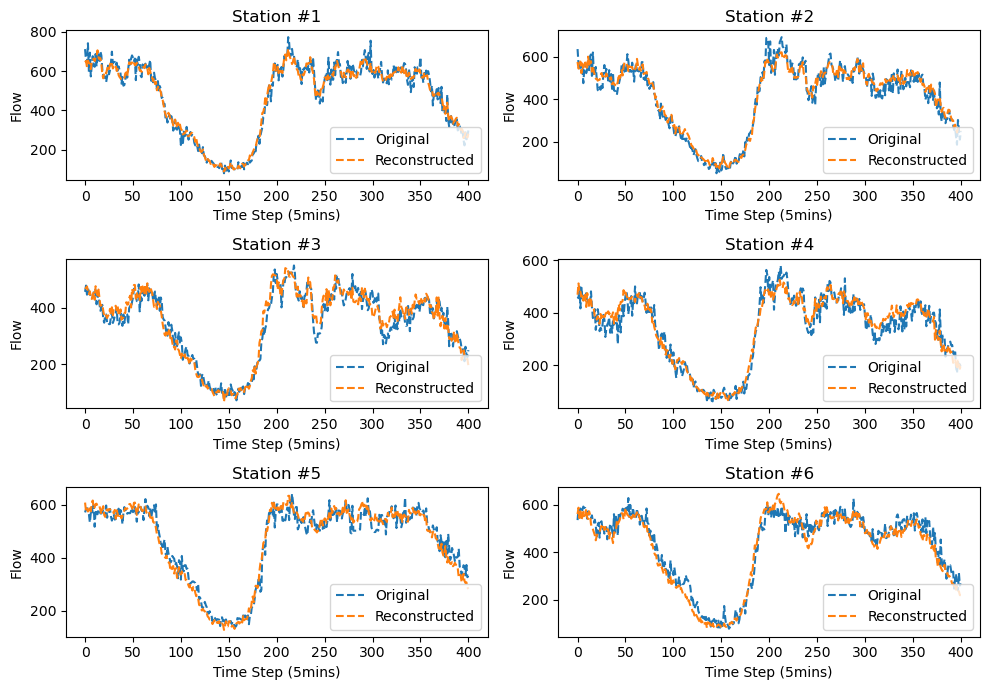

In [7]:
# Create a figure with 5 subplots (one for each column)
fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(10, 7))

# Plot each column in a separate subplot
for row in range(3):
    for col in range(2):
        axs[row, col].plot(100*X_ori[:, row*2 + col], "--", label = 'Original')
        axs[row, col].plot(100*z[:, row*2 + col], "--", label = 'Reconstructed')
        axs[row, col].set_title(f'Station #{(row*2 + col)+1}')
        axs[row, col].set_xlabel('Time Step (5mins)')
        axs[row, col].set_ylabel('Flow')
        axs[row, col].legend(loc='lower right', fontsize='medium')

# Show the figure
plt.tight_layout()
plt.rcParams['font.family'] = 'Times New Roman'
plt.show()
fig.savefig("Figures/Ori_Recon_Plot.png",dpi=300)

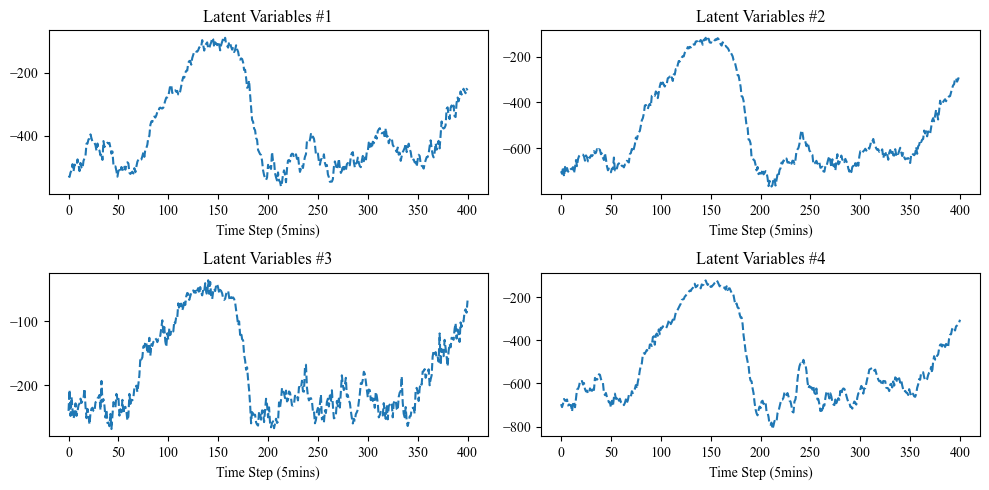

In [8]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10, 5))

# Plot each column in a separate subplot
for row in range(2):
    for col in range(2):
        #axs[row, col].plot(100*X_ori[:, -(row*2 + col)], "--", label = 'Original')
        axs[row, col].plot(100*z[:, -(row*2 + col + 1)], "--", label = 'Reconstructed')
        axs[row, col].set_title(f'Latent Variables #{(row*2 + col)+1}')
        axs[row, col].set_xlabel('Time Step (5mins)')
        #axs[row, col].set_ylabel('Flow')
plt.tight_layout()
plt.rcParams['font.family'] = 'Times New Roman'
plt.show()
fig.savefig("Figures/Latent_Plot.png",dpi=300)

In [9]:
dz_predict = results['dz_predict'].cpu().detach().numpy()
dz = results['dz'].cpu().detach().numpy()

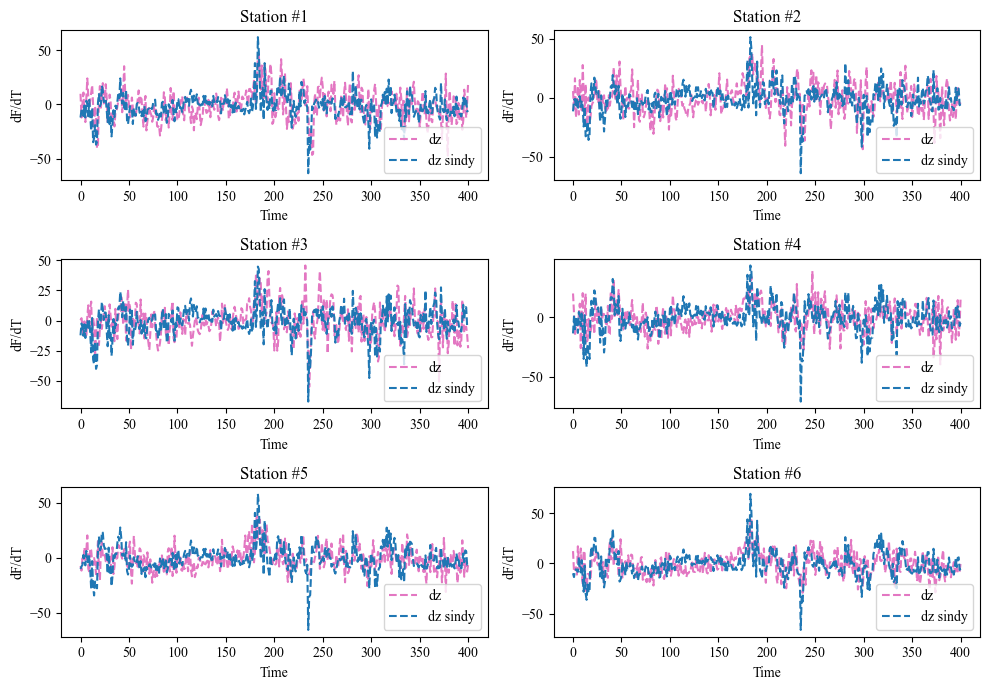

In [10]:
# Create a figure with 5 subplots (one for each column)
fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(10, 7))

# Plot each column in a separate subplot
for row in range(3):
    for col in range(2):
        #axs[row, col].plot(dx_ori[:, row*2 + col], label = 'dx')
        axs[row, col].plot(100*dz[:, row*2 + col], "--", color = '#e377c2', label = 'dz')
        axs[row, col].plot(100*dz_predict[:, row*2 + col], "--", color = '#1f77b4' ,label = 'dz sindy')
        axs[row, col].set_title(f'Station #{(row*2 + col)+1}')
        axs[row, col].set_xlabel('Time')
        axs[row, col].set_ylabel('dF/dT')
        axs[row, col].legend(loc='lower right', fontsize='medium')

# Show the figure
plt.tight_layout()
plt.rcParams['font.family'] = 'Times New Roman'
plt.show()
fig.savefig("Figures/dz_dzSINDy_Plot.png", dpi=300)

# 5mins prediction

In [11]:
from sindy_utils import sindy_library
sim_result_1 = np.zeros(z.shape)
sim_result_2 = np.zeros(z.shape)

In [12]:
for t in range(z.shape[0]):
    z_current = z[t,:].reshape(1,-1)
    Theta_curr = sindy_library(z_current,2,False)
    dz_curr = np.matmul(Theta_curr, sindy_coeff)
    z_next = z_current + dz_curr
    sim_result_1[t,:] = z_next

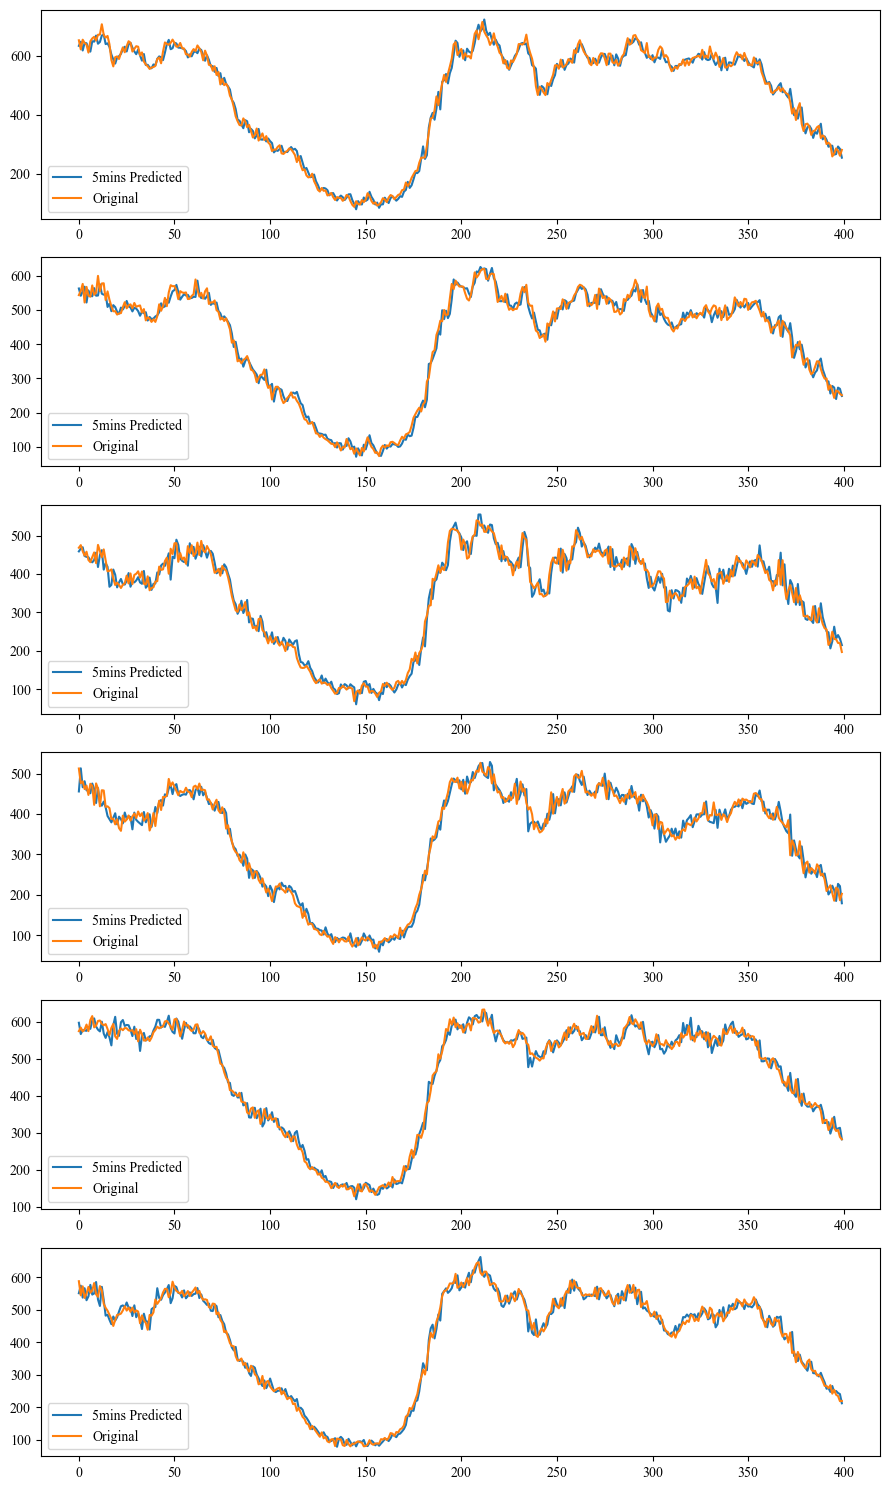

In [21]:
fig, axs = plt.subplots(nrows=params['partial_measurement'], ncols=1, figsize=(9, 15))
for i in range(params['partial_measurement']):
    axs[i].plot(100*sim_result_1[:-1, i], "-", label = '5mins Predicted')
    axs[i].plot(100*z[1:,i], "-", label = 'Original')
    axs[i].legend()
plt.tight_layout()
plt.show()

In [14]:
from sklearn.metrics import mean_squared_error as mse

In [15]:
rmse_i = {}
for i in range(params['partial_measurement']):
    rmse_curr = np.sqrt(mse(100*sim_result_1[:-1, i], 100*z[1:,i]))
    rmse_i[f'Station #{i+1}'] = rmse_curr

In [20]:
import pandas as pd
accuracy = pd.DataFrame(rmse_i, index=[1]).round(2)
accuracy.to_csv("Accuracy_Metric/sindyAE.csv")

# 10mins predictions

In [22]:
for t in range(sim_result_1.shape[0]):
    z_current = sim_result_1[t,:].reshape(1,-1)
    Theta_curr = sindy_library(z_current,2,False)
    dz_curr = np.matmul(Theta_curr, sindy_coeff)
    z_next = z_current + dz_curr
    sim_result_2[t,:] = z_next

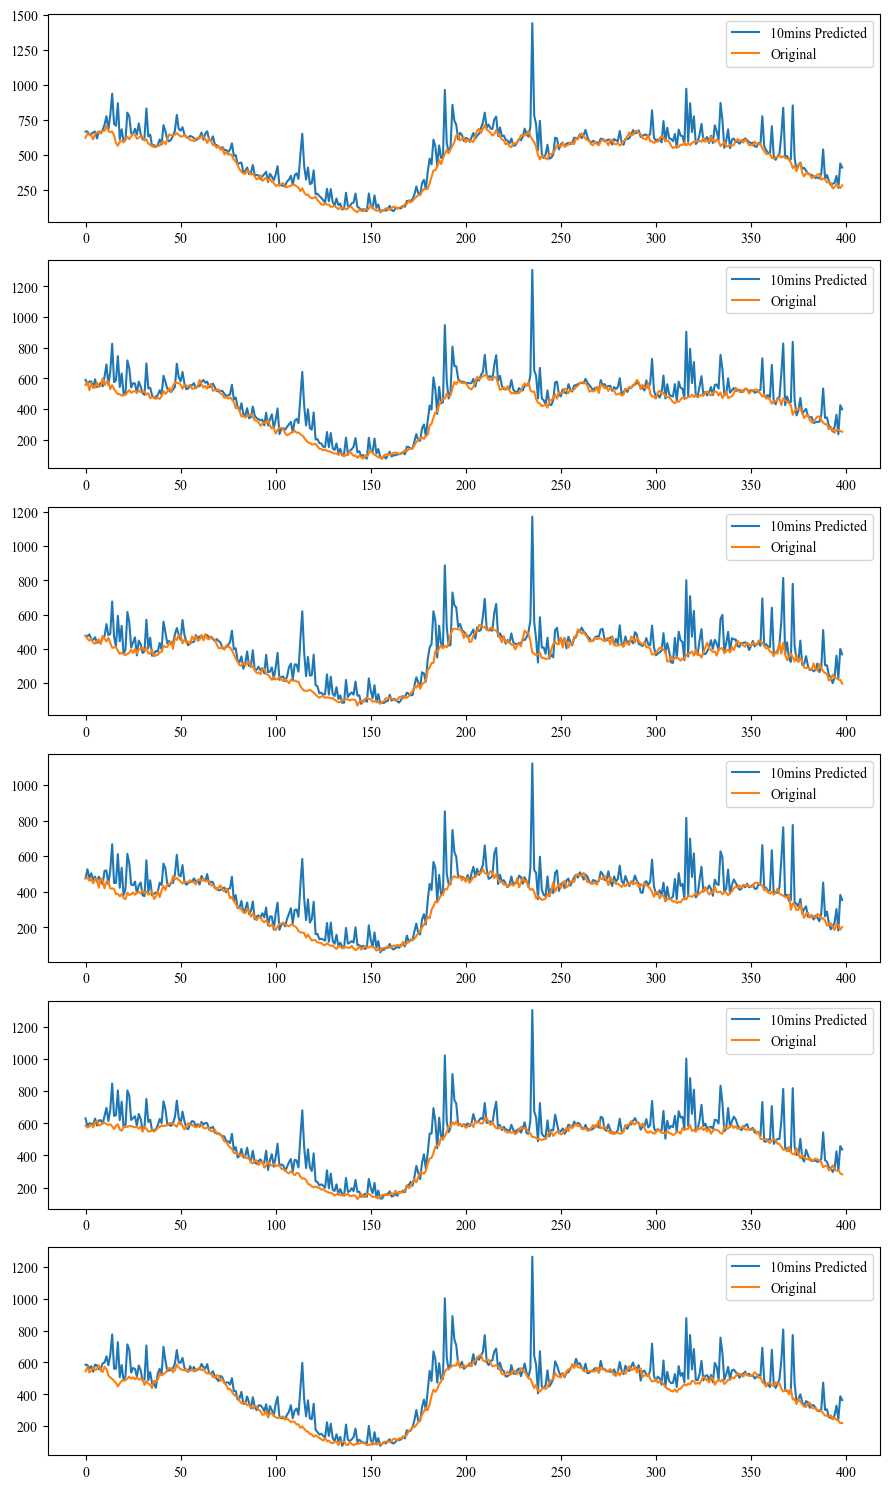

In [23]:
fig, axs = plt.subplots(nrows=params['partial_measurement'], ncols=1, figsize=(9, 15))
for i in range(params['partial_measurement']):
    axs[i].plot(100*sim_result_2[:-2, i], label = '10mins Predicted')
    axs[i].plot(100*z[2:,i], label = 'Original')
    axs[i].legend()
plt.tight_layout()
plt.show()

# Phases

In [18]:
# fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(13, 5))
# fig1 = axs[0].imshow(X_ori, cmap='hot', interpolation='nearest',aspect='auto')
# plt.colorbar(fig1, ax = axs[0])
# axs[0].set_xlabel('Flow Detector Location', fontsize = 15)
# axs[0].set_ylabel('Time (5 mins)', fontsize = 15)
# axs[0].set_title('Original Spatial Dimensions', fontsize = 15)
#
# fig2 = axs[1].imshow(z[:,:params['partial_measurement']], cmap='hot', interpolation='nearest',aspect='auto')
# plt.colorbar(fig2, ax = axs[1])
# axs[1].set_xlabel('Flow Detector Location', fontsize = 15)
# axs[1].set_ylabel('Time (5 mins)', fontsize = 15)
# axs[1].set_title('Reconstructed Spatial Dimensions', fontsize = 15)
# plt.rcParams['font.family'] = 'Times New Roman'
# plt.show()
# fig.savefig("Figures/x_z_heatmap.png")

In [37]:
import random
indices = range(params['partial_measurement'])
index_pair = []
for i in range(params['partial_measurement']):
    for j in range(i+1, params['partial_measurement']):
        index_pair.append((indices[i], indices[j]))

random.seed(66)
index_pair = random.sample(index_pair, 6)

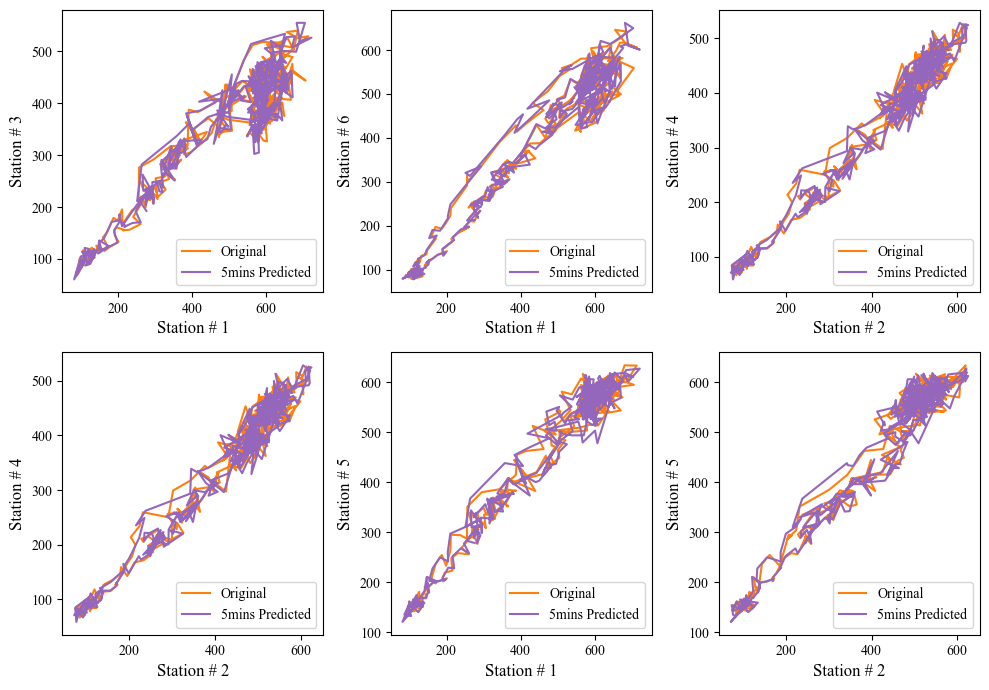

In [38]:
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(10, 7))
for row in range(2):
    for col in range(3):
        index1 = index_pair[row*2 + col][0]
        index2 = index_pair[row*2 + col][1]
        axs[row, col].plot(100 * z[:-1,index1], 100 * z[:-1,index2], color = '#ff7f0e', label = 'Original')
        axs[row, col].plot(100 * sim_result_1[1:,index1], 100 * sim_result_1[1:,index2], color = '#9467bd', label = '5mins Predicted')
        #axs[row, col].plot(100 * X_ori[1:,index1], 100 * X_ori[1:,index2], "--", label = '5mins Predicted')
        axs[row, col].legend(loc='lower right', fontsize='medium')
        axs[row, col].set_xlabel(f'Station # {index1 + 1}', fontsize = 12)
        axs[row, col].set_ylabel(f'Station # {index2 + 1}', fontsize = 12)
plt.tight_layout()
plt.rcParams['font.family'] = 'Times New Roman'
plt.show()
fig.savefig("Figures/predicted_and_z_phase.png", dpi = 300)